In [1]:
IMAGE_PATH = 'data/train/rosneft/images/'
MASK_PATH = 'data/train.csv'
TEST_PATH = 'data/test/rosneft/images/'
SAMPLE_PATH = 'data/sub_baseline_fin.csv'

In [2]:
import os
import albumentations as A
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import cv2

from albumentations.pytorch import ToTensor
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.optim import Adam
from torchvision.models import resnet18

import tqdm
import matplotlib.pyplot as plt

In [3]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x


class ConvBn2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)):
        super(ConvBn2d, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,
                              bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        # self.bn = SynchronizedBatchNorm2d(out_channels)

    def forward(self, z):
        x = self.conv(z)
        x = self.bn(x)
        return x


class Decoder(nn.Module):
    def __init__(self, in_channels, channels, out_channels):
        super(Decoder, self).__init__()
        self.conv1 = ConvBn2d(in_channels, channels, kernel_size=3, padding=1)
        self.conv2 = ConvBn2d(channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.upsample(x, scale_factor=2, mode='bilinear')
        x = F.relu(self.conv1(x), inplace=True)
        x = F.relu(self.conv2(x), inplace=True)
        return x


class DecoderSEBlockV2(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.block = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear'),
            ConvRelu(in_channels, middle_channels),
            ConvRelu(middle_channels, out_channels))
        # SEBlock(planes=out_channels, reduction=16))

    def forward(self, x):
        return self.block(x)

In [4]:
class UnetResnet34(nn.Module):
    def __init__(self, num_classes=1, num_filters=16, pretrained=True):
        super().__init__()
        self.num_classes = num_classes
        self.pool = nn.MaxPool2d(2, 2)
        encoder = resnet18(pretrained=pretrained)
        self.relu = nn.ReLU(inplace=True)

        self.encoder = nn.ModuleList([
            nn.Sequential(
                encoder.conv1,
                encoder.bn1,
                encoder.relu,
                self.pool),
            encoder.layer1,
            encoder.layer2,
            encoder.layer3,
            encoder.layer4])

        self.avgpool = nn.AvgPool2d(3)
        self.fc = nn.Linear(512, 1)

        self.center = DecoderSEBlockV2(512, num_filters * 8 * 2, num_filters * 8)

        self.decoder = nn.ModuleList([
            DecoderSEBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8),
            DecoderSEBlockV2(256 + num_filters * 8, num_filters * 8 * 2, num_filters * 8),
            DecoderSEBlockV2(128 + num_filters * 8, num_filters * 4 * 2, num_filters * 2),
            DecoderSEBlockV2(64 + num_filters * 2, num_filters * 2 * 2, num_filters * 2 * 2),
        ])

        self.dec1 = DecoderSEBlockV2(num_filters * 2 * 2, num_filters * 2 * 2, num_filters)
        self.dec0 = ConvRelu(num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        encoder_results = []
        for stage in self.encoder:
            x = stage(x)
            encoder_results.append(x.clone())

        x = self.center(self.pool(x))

        for i, decoder in enumerate(self.decoder):
            x = self.decoder[i](torch.cat([x, encoder_results[-i - 1]], 1))

        x = self.dec1(x)
        x = self.dec0(x)
        x = self.final(x)

        return x

In [5]:
class CrossEntropyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(CrossEntropyLoss, self).__init__()
        self.loss = nn.CrossEntropyLoss(weight, size_average)

    def forward(self, logits, targets):
        targets = targets.type(torch.cuda.LongTensor)
        return self.loss(logits, targets)

    
class MultiDice(nn.Module):
    """
    Calculate Dice with averaging per classes and then per batch 
    """
    def __init__(self,):
        super(MultiDice, self).__init__()

    def forward(self, outputs, targets):
        smooth = 1e-15
        prediction = outputs.softmax(dim=1)
        
        dices = []
        
        for val in range(1, 8):
            target = (targets == val).float().squeeze()
            ch_pred = prediction[:, val]
            intersection = torch.sum(ch_pred * target, dim=(1,2))
            union = torch.sum(ch_pred, dim=(1,2)) + torch.sum(target, dim=(1,2))      
            dice_part = (2 * intersection + smooth) / (union + smooth)
        dices.append(dice_part.mean())
        return torch.mean(dice_part)

In [6]:
def rle2mask(mask_rle, shape):
    """
    mask_rle: run-length as string formated (start length)ы
    shape: (width,height) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """
    if mask_rle != mask_rle:
        return np.zeros_like(shape)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [7]:
train = pd.read_csv(MASK_PATH)

valid_ids = np.random.choice(train.ImageId.unique(), size=int(0.3 * train.ImageId.nunique()), replace=False)

valid = train[train.ImageId.isin(valid_ids)]
train = train[~train.ImageId.isin(valid_ids)]

In [8]:
train_transforms = A.Compose([
    A.Resize(512, 384),
    A.HorizontalFlip(p=0.5),
    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225))
    ])

valid_transforms = A.Compose([
    A.Resize(512, 384),
    A.HorizontalFlip(p=0.5),
    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)),
])

In [9]:
class TrainDataset():
    def __init__(self, image_dir, train, transform):
        self.image_dir = image_dir
        self.train = train
        self.transform = transform

    def __getitem__(self, index):
        img_name = self.train.iloc[index]['ImageId']
        
        path = os.path.join(self.image_dir, img_name)
        img = cv2.imread(path)
        ce_mask = [
            (i + 1) * rle2mask(rle, shape=(img.shape[1], img.shape[0])) \
                for i, rle in enumerate(self.train[self.train['ImageId']==img_name]['EncodedPixels'])
        ]
        ce_mask = np.sum(ce_mask, axis=0, dtype=np.float32)
        result = self.transform(
            image=img, 
            mask=ce_mask
        )
        
        result = {
            'image': ToTensor()(image=result['image'])['image'], 
            'mask': torch.Tensor(result['mask'])
        }
        return result
    
    def __len__(self, ):
        return len(self.train)
    
class TestDataset():
    def __init__(self, image_dir, test, transform):
        self.image_dir = image_dir
        self.test = test
        self.transform = transform

    def __getitem__(self, index):
        img_name = self.test.iloc[index]['ImageId']
        
        path = os.path.join(self.image_dir, img_name)
        img = cv2.imread(path)
        
        result = self.transform(
            image=img, 
        )
        
        result = {
            'image': ToTensor()(image=result['image'])['image'], 
        }
        return result
    
    def __len__(self, ):
        return len(self.test)

In [10]:
train_dataset = TrainDataset(
    image_dir=IMAGE_PATH, 
    train=train, 
    transform=train_transforms
)

valid_dataset = TrainDataset(
    image_dir=IMAGE_PATH, 
    train=valid, 
    transform=valid_transforms
)

In [11]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=16, 
    shuffle=True,
    num_workers=10,
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=8,                
    shuffle=False,
    num_workers=10,
)

In [12]:
device = torch.device('cuda')

In [13]:
criterion = CrossEntropyLoss()
metric = MultiDice()

/home/core/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [14]:
model = UnetResnet34(
    num_classes=8,
    num_filters=16,
    pretrained=False,
)

model = nn.DataParallel(model).to(device)

optimizer = Adam(model.parameters(), lr=1e-4)
schelduer = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [15]:
best_model = 0
for epoch in tqdm.tqdm_notebook(range(30)):
    running_loss = 0.0
    value = 0.0
    
    model.train()
    for i, data in enumerate(train_loader):
        inputs = Variable(data['image']).to(device)
        masks = Variable(data['mask']).to(device)

        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, masks)
        metric_value = metric(outputs, masks) 
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        value += metric_value.item()                    
        print(f"[TRAIN][BATCH {i}/{len(train_loader)}] metric: {value / (i + 1)} loss: {running_loss / (i + 1)}\r", end="")   
        
    running_loss = 0.0
    value = 0.0
    model.eval()
    for i, data in enumerate(valid_loader):
        inputs = Variable(data['image']).to(device)
        masks = Variable(data['mask']).to(device)

        outputs = model(inputs)
        loss = criterion(outputs, masks)
        metric_value = metric(outputs, masks) 
        
        running_loss += loss.item()
        value += metric_value.item()                   
        
        print(f"[VALID][BATCH {i}/{len(valid_loader)}] metric: {value / (i + 1)} loss: {running_loss / (i + 1)}\r", end="")
        
    schelduer.step(running_loss / (i + 1))
    
    if best_model < value:
        torch.save(model.state_dict(), 'best_model.pth')

/home/core/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


KeyboardInterrupt: 

In [21]:
model.eval()
for i, data in enumerate(valid_loader):
    inputs = Variable(data['image']).to(device)
    masks = Variable(data['mask']).to(device)
    outputs = model(inputs)
    

In [23]:
import torchvision

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


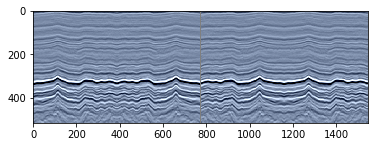

In [25]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(torchvision.utils.make_grid(inputs.cpu()))

<Figure size 1440x720 with 0 Axes>

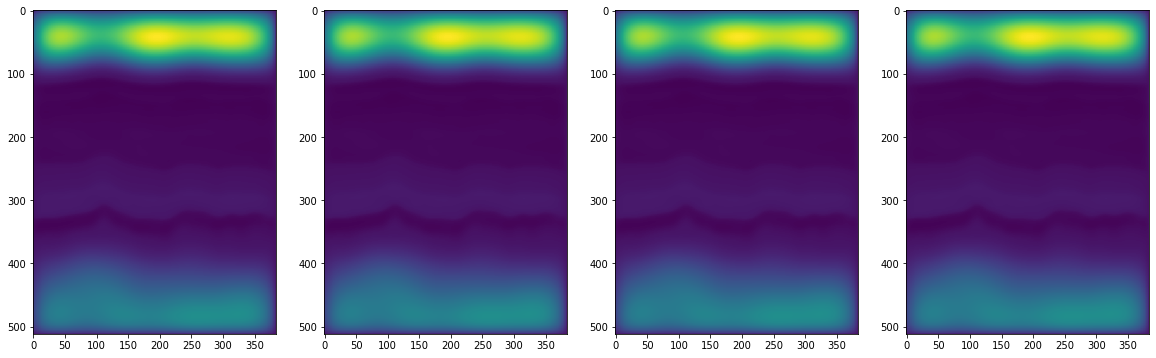

<Figure size 2160x2880 with 0 Axes>

<Figure size 2160x2880 with 0 Axes>

<Figure size 2160x2880 with 0 Axes>

<Figure size 2160x2880 with 0 Axes>

In [60]:
fig = plt.figure(figsize=(20, 10))
fig, ax = plt.subplots(nrows=1, ncols=outputs.size(0), figsize=(20, 10))

for i in range(outputs.size(0)):
    # do whatever you do with outputs[i, ...]
    # ...
    
    for row in ax:
        row.imshow(outputs.cpu().detach().numpy()[i,:1, :].reshape((512, 384)))
    plt.figure(figsize=(30, 40))
    plt.show()

In [ ]:
fig = plt.figure(figsize=(20, 10))
fig, ax = plt.subplots(nrows=1, ncols=outputs.size(0), figsize=(20, 10))

for i in range(outputs.size(0)):
    # do whatever you do with outputs[i, ...]
    # ...
    
    for row in ax:
        row.imshow(outputs.cpu().detach().numpy()[i,:1, :].reshape((512, 384)))
    plt.figure(figsize=(30, 40))
    plt.show()

In [53]:
row

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe346971350>,
      dtype=object)

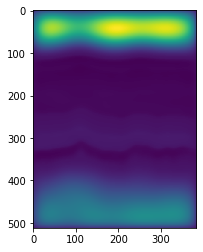

In [44]:
plt.imshow(outputs.cpu().detach().numpy()[i,:1, :].reshape((512, 384)))

In [46]:
plt.imshow(outputs.cpu().detach().numpy()[i,:, :].reshape((512, 384)))

ValueError: cannot reshape array of size 1572864 into shape (512,384)

In [26]:
imshow(torchvision.utils.make_grid(outputs.cpu()))

RuntimeError: The size of tensor a (3) must match the size of tensor b (8) at non-singleton dimension 0

In [17]:
test = pd.read_csv(SAMPLE_PATH)
test_ids = test.drop_duplicates('ImageId')

In [18]:
test_dataset = TestDataset(
    image_dir=TEST_PATH, 
    test=test_ids, 
    transform=valid_transforms
)

In [19]:
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=1,                
    shuffle=False,
    num_workers=11,
)

In [ ]:
img_names = test_ids.ImageId.values
shapes = {name: cv2.imread(os.path.join(TEST_PATH, name), 0).shape for name in img_names if name in os.listdir(TEST_PATH)}

In [ ]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def out2rle(outputs, i):
    rles = []
    
    smooth = 1e-15
    prediction = outputs.detach().cpu().softmax(dim=1).numpy()

    for j, sample in enumerate(prediction):
        for val in range(1, 8):
            ch_pred = sample[val]
            shape = shapes[img_names[8*i+j]]
            ch_pred = cv2.resize(ch_pred, (shape[1], shape[0]))
            rles.append(mask2rle(ch_pred.T > 0.5))
    return rles

In [20]:
rles = []

for i, data in tqdm.tqdm_notebook(enumerate(test_loader), total=len(test_loader)):
    inputs = Variable(data['image']).to(device)
    outputs = model(inputs)
    
    break
    rles += out2rle(outputs, i)

AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/core/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/core/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/core/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-9-0ecd1293df58>", line 44, in __getitem__
    image=img,
  File "/home/core/anaconda3/lib/python3.7/site-packages/albumentations/core/composition.py", line 176, in __call__
    data = t(force_apply=force_apply, **data)
  File "/home/core/anaconda3/lib/python3.7/site-packages/albumentations/core/transforms_interface.py", line 87, in __call__
    return self.apply_with_params(params, **kwargs)
  File "/home/core/anaconda3/lib/python3.7/site-packages/albumentations/core/transforms_interface.py", line 94, in apply_with_params
    params = self.update_params(params, **kwargs)
  File "/home/core/anaconda3/lib/python3.7/site-packages/albumentations/core/transforms_interface.py", line 142, in update_params
    params.update({"cols": kwargs["image"].shape[1], "rows": kwargs["image"].shape[0]})
AttributeError: 'NoneType' object has no attribute 'shape'


In [ ]:
test['EncodedPixels'] = rles

print(test.head())

test.to_csv('submission.csv', index=False)

In [ ]:
test.head()